# Accidentes Aéreos

## Introducción

Los accidentes aéreos son eventos trágicos que pueden tener consecuencias devastadoras. La industria de la aviación, las autoridades reguladoras y los investigadores trabajan incansablemente para mejorar la seguridad de la aviación y prevenir futuros accidentes.

La Organización de Aviación Civil Internacional (OACI), organismo de la Organización de las Naciones Unidas, quiere investigar en profundidad los accidentes producidos desde inicios del siglo XX. Para ello, ha contratado a una consultora de datos para que realice un análisis de datos relacionado a esto, junto a un dashboard que complemente los análisis con sus visualizaciones.

El objetivo de este proyecto es obtener una comprensión más profunda de las causas de los accidentes aéreos. Esto ayudará a la OACI a identificar áreas donde se pueden implementar mejoras para mejorar la seguridad.

## Objetivos

El proyecto tiene los siguientes objetivos:

- Realizar un análisis de datos de los accidentes aéreos producidos desde inicios del siglo XX.

Los siguientes objetivos específicos:

- Identificar patrones históricos en la frecuencia de accidentes aéreos a lo largo de los años.
- Investigar la relación entre el tipo de vuelo.
- Identificar los tipos de aviones más comúnmente involucrados en accidentes aéreos.
- Investigar las posibles causas detrás de las categorías con alta incidencia.
- Investigar las razones detrás de la alta incidencia de accidentes en esos destinos.
- Desarrollar un dashboard que complemente los análisis con sus visualizaciones.

# Metodología:

El proyecto se llevará a cabo en dos fases:

- Fase 1: Recopilación y limpieza de datos.
- Fase 2: Análisis de datos y desarrollo del dashboard.

# Fase 1: EDA (Analisis Exploratorio de los Datos)

## 1. Compresión de datos:

In [1]:
# Importe de librerías:
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


# Especifica la ruta del archivo CSV que deseas leer
archivo_csv = 'AccidentesAviones.csv'

# Usa pd.read_csv() para leer el archivo CSV y convertirlo en un DataFrame
accidentes= pd.read_csv(archivo_csv)

accidentes.head(2)

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...


In [2]:
# Verificación del numero tota de filas y columnas
num_filas, num_columnas = accidentes.shape

# Imprime los resultados
print(f'Número total de filas: {num_filas}')
print(f'Número total de columnas: {num_columnas}')

Número total de filas: 5008
Número total de columnas: 18


In [3]:
# Se reemplaza caracter por '?' por un valor vacío, con el objetivo de contabilizar.

# Reemplazar el signo de interrogación por un valor vacío
accidentes.replace('?', '', inplace=True)

# Identificación de Columnas Disponibles:

nombres_columnas = accidentes.columns

# Imprime la lista de nombres de columnas
print('Nombres de columnas en el conjunto de datos:')
for columna in nombres_columnas:
    print(columna)

Nombres de columnas en el conjunto de datos:
Unnamed: 0
fecha
HORA declarada
Ruta
OperadOR
flight_no
route
ac_type
registration
cn_ln
all_aboard
PASAJEROS A BORDO
crew_aboard
cantidad de fallecidos
passenger_fatalities
crew_fatalities
ground
summary


In [4]:
# Renombrado de columnas:

# Renombrado columnas
nombres_nuevos = {'Unnamed: 0': 'sin_nombre','HORA declarada': 'hora', 'Ruta': 'destino','OperadOR':'compañia','flight_no': 'num_vuelo','route':'tipo_vuelo','ac_type':'tipo_avion','registration':'registro','cn_ln':'id_aeronave','all_aboard':'total_ocupantes','PASAJEROS A BORDO':'pasajeros_a_bordo','crew_aboard':'tripulacion_a_bordo','cantidad de fallecidos':'fallecidos','passenger_fatalities':'pasajeros_fallecidos','crew_fatalities':'tripulacion_fallecida','ground':'fallecidos_en_tierra','summary':'resumen'}

# Aplica el renombrado de columnas
accidentes.rename(columns=nombres_nuevos, inplace=True)

In [5]:
# Obtiene los tipos de datos de cada columna
tipos_de_datos = accidentes.dtypes

# Imprime los tipos de datos de cada columna
print('Tipos de datos de cada columna en el conjunto de datos:')
print(tipos_de_datos)

Tipos de datos de cada columna en el conjunto de datos:
sin_nombre                int64
fecha                    object
hora                     object
destino                  object
compañia                 object
num_vuelo                object
tipo_vuelo               object
tipo_avion               object
registro                 object
id_aeronave              object
total_ocupantes          object
pasajeros_a_bordo        object
tripulacion_a_bordo      object
fallecidos               object
pasajeros_fallecidos     object
tripulacion_fallecida    object
fallecidos_en_tierra     object
resumen                  object
dtype: object


In [6]:
# Función para convertir el formato de la columna 'hora'
def convertir_hora(hora_original):
    try:
        # Asegurarse de que la hora tenga al menos dos dígitos
        if len(hora_original) < 2:
            hora_original = '0' + hora_original
        
        hora_obj = datetime.strptime(hora_original, '%H%M')
        return hora_obj.strftime('%H:%M')
    except ValueError:
        return None  # Devuelve None para valores no válidos

# Función para convertir el formato de la columna 'fecha'
def convertir_fecha(fecha_original):
    if fecha_original and '/' not in fecha_original:
        fecha_obj = datetime.strptime(fecha_original, '%B %d, %Y')
        return fecha_obj.strftime('%d/%m/%Y')
    else:
        return fecha_original  

# Aplicar las funciones de conversión a las columnas 'fecha' y 'hora'
accidentes['fecha'] = accidentes['fecha'].apply(convertir_fecha)
# Limpiar la columna 'hora' eliminando caracteres no numéricos
accidentes['hora'] = accidentes['hora'].str.replace('[^0-9]', '', regex=True)
# Aplicar la función de conversión a la columna 'hora'
accidentes['hora'] = accidentes['hora'].apply(convertir_hora)
# Convertir la columna 'fecha' a tipo datetime
accidentes['fecha'] = pd.to_datetime(accidentes['fecha'], format='%d/%m/%Y')




# Lista de columnas que deseas convertir a tipo int
columnas_a_convertir = ['total_ocupantes', 'pasajeros_a_bordo', 'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos', 'tripulacion_fallecida','fallecidos_en_tierra']
# Itera a través de las columnas y convierte sus valores a tipo int
for columna in columnas_a_convertir:
    accidentes[columna] = pd.to_numeric(accidentes[columna], errors='coerce', downcast='integer')

In [7]:
# Se imputan los faltantes de acuerdo a valor modal de la columna correspondiente a tripulación


# Tomando en consideración que la tripulación de viaje aero permanece casi constante, los valores faltantes fueron reemplazados por moda de dicha columna:
valor_modal_tripulacion = accidentes['tripulacion_a_bordo'].mode().iloc[0]  # Calcula la moda
# Reemplazar valores faltantes con la moda
accidentes['tripulacion_a_bordo'].fillna(valor_modal_tripulacion, inplace=True)
# Verifica si los valores faltantes se han reemplazado correctamente
print("Valores faltantes en tripulacion_a_bordo después del reemplazo:", accidentes['tripulacion_a_bordo'].isnull().sum())



# Supongamos que 'df' es tu DataFrame
valor_modal_tripulacion = accidentes['tripulacion_fallecida'].mode().iloc[0]  # Calcula la moda
# Reemplazar valores faltantes con la moda
accidentes['tripulacion_fallecida'].fillna(valor_modal_tripulacion, inplace=True)
# Verifica si los valores faltantes se han reemplazado correctamente
print("Valores faltantes en tripulacion_fallecida después del reemplazo:", accidentes['tripulacion_fallecida'].isnull().sum())

Valores faltantes en tripulacion_a_bordo después del reemplazo: 0
Valores faltantes en tripulacion_fallecida después del reemplazo: 0


In [8]:
# La columna 'total_ocupantes' representa la suma de pasajeros y tripulación a bordo. Por lo tanto, los valores faltantes en la columna 'pasajeros_a_bordo' 
# se calcularon mediante la diferencia entre 'total_ocupantes' y 'tripulación_a_bordo'."

#Se toma la decisión de calcular el valor por diferencia
accidentes['diferencia'] = accidentes['total_ocupantes'] - accidentes['tripulacion_a_bordo']

# Reemplaza valores faltantes en 'pasajeros_a_bordo' con los valores de 'diferencia'
accidentes['pasajeros_a_bordo'].fillna(accidentes['diferencia'], inplace=True)

# Verifica si los valores faltantes se han reemplazado correctamente
print("Valores faltantes en pasajeros_a_bordo después del reemplazo:", accidentes['pasajeros_a_bordo'].isnull().sum())

# Luego, puedes eliminar la columna 'diferencia' si ya no la necesitas
accidentes.drop('diferencia', axis=1, inplace=True)

Valores faltantes en pasajeros_a_bordo después del reemplazo: 17


In [9]:
# Contar la cantidad de valores faltantes en cada columna, incluyendo espacios en blanco
valores_faltantes_por_columna = accidentes.isna().sum() + accidentes.isin(['']).sum()

# Calcular el porcentaje de valores faltantes en cada columna
porcentaje_valores_faltantes = (valores_faltantes_por_columna / len(accidentes)) * 100

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    'Valores Faltantes': valores_faltantes_por_columna,
    'Porcentaje Faltantes (%)': porcentaje_valores_faltantes
})

# Imprimir el nuevo DataFrame
print(resultados_df)

                       Valores Faltantes  Porcentaje Faltantes (%)
sin_nombre                             0                  0.000000
fecha                                  0                  0.000000
hora                                1504                 30.031949
destino                                5                  0.099840
compañia                              10                  0.199681
num_vuelo                           3682                 73.522364
tipo_vuelo                           763                 15.235623
tipo_avion                            13                  0.259585
registro                             272                  5.431310
id_aeronave                          667                 13.318690
total_ocupantes                       17                  0.339457
pasajeros_a_bordo                     17                  0.339457
tripulacion_a_bordo                    0                  0.000000
fallecidos                             8                  0.15

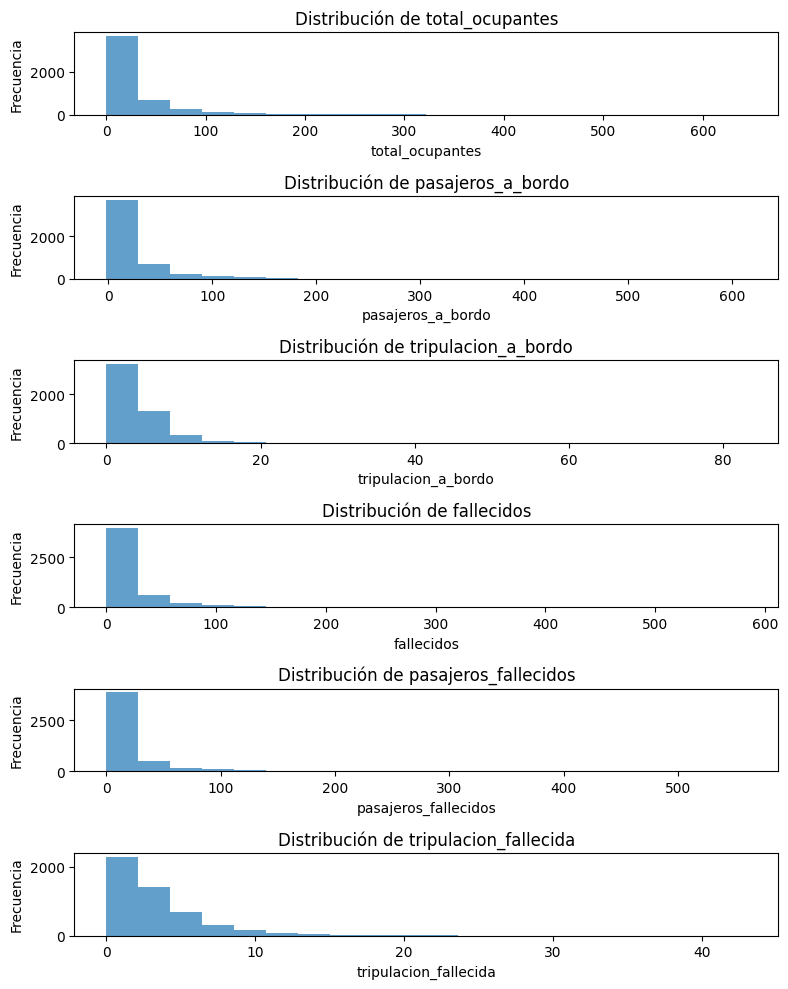

In [10]:
# Se crean gráficos con la finalidad de analizar las variables relevantes de acuerdo al dataset:
# Lista de columnas numéricas relevantes
columnas_relevantes = ['total_ocupantes', 'pasajeros_a_bordo', 'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos', 'tripulacion_fallecida']

# Crear subplots para mostrar histogramas de cada columna
fig, axes = plt.subplots(nrows=len(columnas_relevantes), ncols=1, figsize=(8, 10))

# Generar histogramas para cada columna relevante
for i, columna in enumerate(columnas_relevantes):
    axes[i].hist(accidentes[columna].dropna(), bins=20, alpha=0.7)
    axes[i].set_title(f'Distribución de {columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

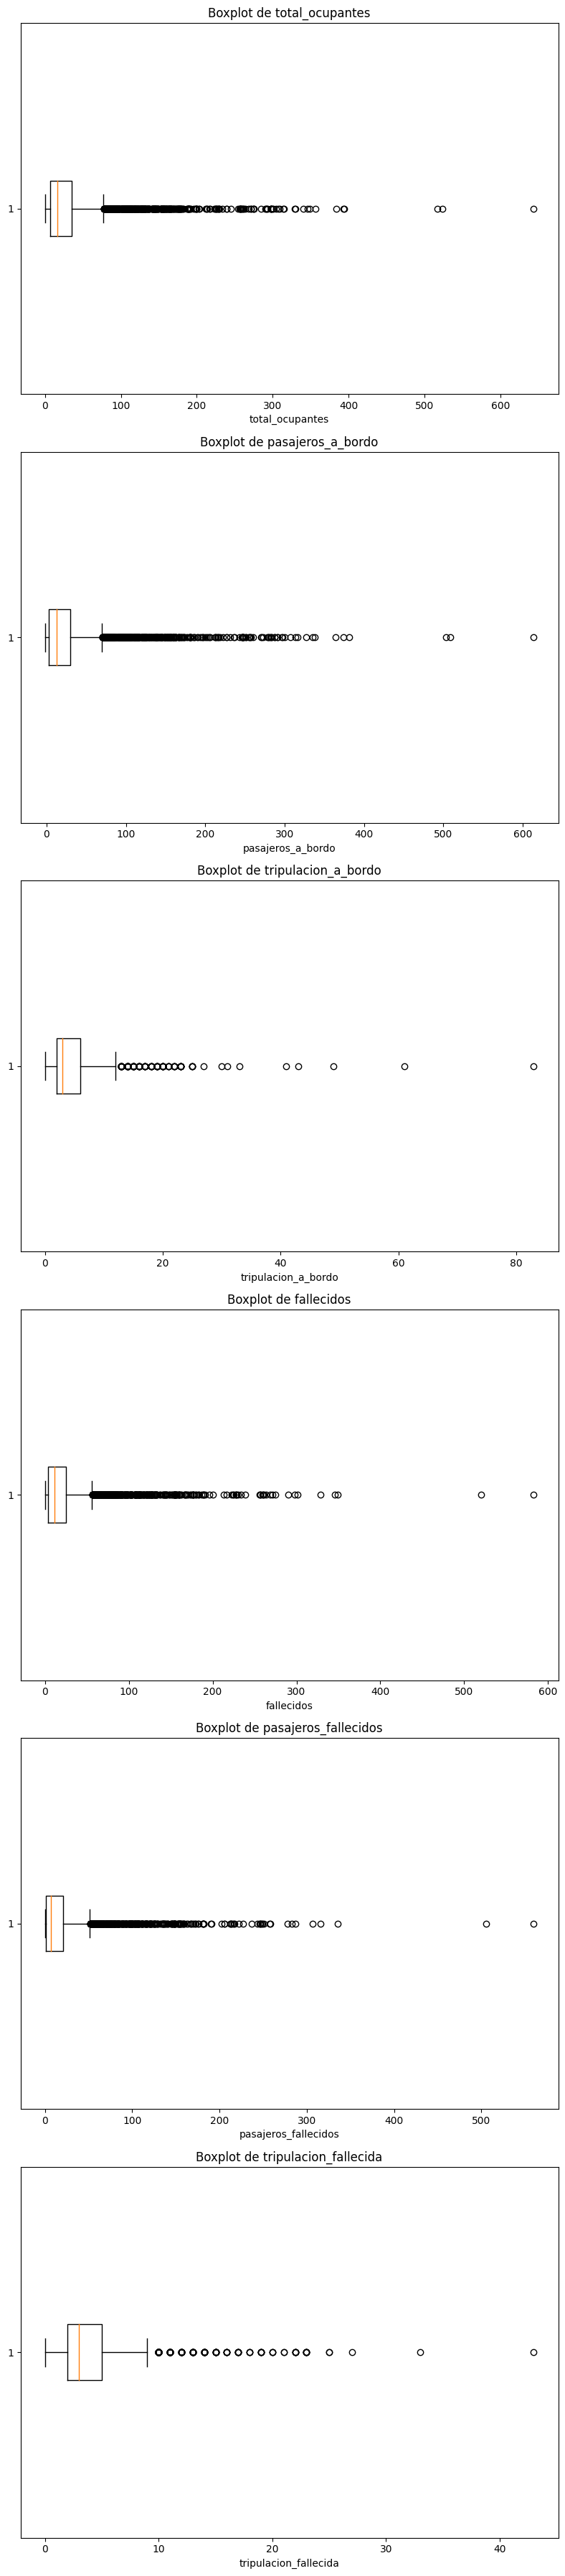

In [11]:
# Lista de nombres de columnas numéricas
columnas_numericas = ['total_ocupantes', 'pasajeros_a_bordo', 'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos', 'tripulacion_fallecida']

# Crear subplots para los boxplots
fig, axes = plt.subplots(nrows=len(columnas_numericas), figsize=(8, 6 * len(columnas_numericas)))

# Iterar sobre las columnas numéricas y crear un boxplot para cada una
for i, columna in enumerate(columnas_numericas):
    ax = axes[i]
    ax.boxplot(accidentes[columna].dropna(), vert=False)  # Eliminar NaN y crear el boxplot
    ax.set_title(f'Boxplot de {columna}')
    ax.set_xlabel(columna)

plt.tight_layout()
plt.show()

In [12]:
# Supongamos que 'df' es tu DataFrame y estas son las cuatro columnas con valores atípicos
columnas_con_atipicos = ['total_ocupantes','pasajeros_a_bordo','tripulacion_a_bordo','fallecidos','pasajeros_fallecidos','tripulacion_fallecida']

# Iterar sobre las columnas con valores atípicos
for columna in columnas_con_atipicos:
    Q1 = accidentes[columna].quantile(0.25)
    Q3 = accidentes[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar y eliminar valores atípicos en la columna actual
    accidentes = accidentes[(accidentes[columna] >= limite_inferior) & (accidentes[columna] <= limite_superior)]

In [13]:

# Convertir la columna 'hora' a tipo datetime
accidentes['hora'] = pd.to_datetime(accidentes['hora'], format='%H:%M').dt.time

In [14]:
# Contar la cantidad de valores faltantes en cada columna, incluyendo espacios en blanco
valores_faltantes_por_columna = accidentes.isna().sum() + accidentes.isin(['']).sum()

# Calcular el porcentaje de valores faltantes en cada columna
porcentaje_valores_faltantes = (valores_faltantes_por_columna / len(accidentes)) * 100

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    'Valores Faltantes': valores_faltantes_por_columna,
    'Porcentaje Faltantes (%)': porcentaje_valores_faltantes
})

# Imprimir el nuevo DataFrame
print(resultados_df)

                       Valores Faltantes  Porcentaje Faltantes (%)
sin_nombre                             0                  0.000000
fecha                                  0                  0.000000
hora                                1220                 32.699008
destino                                5                  0.134012
compañia                               6                  0.160815
num_vuelo                           3029                 81.184669
tipo_vuelo                           539                 14.446529
tipo_avion                             3                  0.080407
registro                             145                  3.886358
id_aeronave                          446                 11.953900
total_ocupantes                        0                  0.000000
pasajeros_a_bordo                      0                  0.000000
tripulacion_a_bordo                    0                  0.000000
fallecidos                             0                  0.00

In [15]:
# Obtiene los tipos de datos de cada columna
tipos_de_datos = accidentes.dtypes

# Imprime los tipos de datos de cada columna
print('Tipos de datos de cada columna en el conjunto de datos:')
print(tipos_de_datos)

Tipos de datos de cada columna en el conjunto de datos:
sin_nombre                        int64
fecha                    datetime64[ns]
hora                             object
destino                          object
compañia                         object
num_vuelo                        object
tipo_vuelo                       object
tipo_avion                       object
registro                         object
id_aeronave                      object
total_ocupantes                 float64
pasajeros_a_bordo               float64
tripulacion_a_bordo             float64
fallecidos                      float64
pasajeros_fallecidos            float64
tripulacion_fallecida           float64
fallecidos_en_tierra            float64
resumen                          object
dtype: object


In [16]:
# Se procede a imputar hora con la predicción de modelo automatico, para ser más preciso en la imputación
# Convierte la columna 'hora' en minutos desde la medianoche.
accidentes['hora'] = accidentes['hora'].apply(lambda x: x.hour * 60 + x.minute)

# Divide el DataFrame en dos partes: una con valores de hora conocidos y otra con valores faltantes.
known_time_df = accidentes.dropna(subset=['hora'])  # 'hora' es la columna de hora que quieres imputar.
unknown_time_df = accidentes[accidentes['hora'].isnull()]

# Supongamos que tienes otras variables que deseas utilizar para predecir la hora, agrégalas a esta lista.
features = ['total_ocupantes', 'pasajeros_a_bordo', 'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos', 'tripulacion_fallecida']

# Preparar los datos de entrada y salida para el modelo.
X = known_time_df[features]
y = known_time_df['hora']

# Divide el conjunto de datos de tiempo conocido en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrena un modelo de regresión (puedes utilizar otros algoritmos si lo deseas).
model = LinearRegression()
model.fit(X_train, y_train)

# Realiza predicciones para los valores de hora faltantes.
imputed_times = model.predict(unknown_time_df[features])

# Agrega los valores imputados de hora al DataFrame original.
unknown_time_df['hora'] = imputed_times

# Combina el DataFrame con valores imputados con el DataFrame original.
accidentes = pd.concat([known_time_df, unknown_time_df])

# Convierte los valores numéricos en minutos de 'hora' en objetos de tiempo en formato 'HH:MM'.
accidentes['hora'] = accidentes['hora'].apply(lambda x: datetime.min + timedelta(minutes=x))
accidentes['hora'] = accidentes['hora'].apply(lambda x: x.strftime('%H:%M'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_90172\811358437.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_time_df['hora'] = imputed_times


In [17]:
# Se crea columna de pais, a partir de la columna destino:
# Función para extraer el país utilizando expresiones regulares
def extraer_pais(texto):
    # Patrón para encontrar el país después de la coma
    patron = r',\s*(\w+)$'
    coincidencias = re.search(patron, texto)
    if coincidencias:
        return coincidencias.group(1)
    else:
        return None

# Aplicar la función a la columna "destino" para extraer el país
accidentes['pais'] = accidentes['destino'].apply(extraer_pais)

In [18]:
# Se procede a imputar columna de tipo string con "imputación con un valor estático"
# Lista de columnas a imputar con "sin dato" en caso de valores nulos o vacíos.
columnas_a_imputar = ['destino','compañia','tipo_vuelo', 'tipo_avion', 'registro', 'id_aeronave','resumen','pais']

# Itera a través de las columnas y realiza la imputación.
for columna in columnas_a_imputar:
    accidentes[columna].fillna('sin dato', inplace=True)
    accidentes[columna] = accidentes[columna].apply(lambda x: 'sin dato' if pd.isnull(x) or x.strip() == '' else x)


# La columna num_vuelo y la columna sin nombre.En el caso de la columna num_vuelo será imputada debido que presenta el 81% de datos faltantes:
# Eliminar las columnas 'sin_nombre' y 'num_vuelo' del DataFrame
columnas_a_eliminar = ['sin_nombre', 'num_vuelo']
accidentes = accidentes.drop(columnas_a_eliminar, axis=1)


In [19]:
# Se crea columna de año y mes que serán útil para las visualizaciones:
# Extrae el año de la columna 'fecha' y crea una nueva columna llamada 'anio'.
accidentes['anio'] = accidentes['fecha'].dt.year

# Extrae el mes de la columna 'fecha' y crea una nueva columna llamada 'mes'.
accidentes['mes'] = accidentes['fecha'].dt.month


In [20]:
# Busquedad de palabras claves en la columna resumen para posterior categorización de la misma:
palabras_clave = ["pilot error", "weather conditions", "engine failure", "collision", "fire", "structural failure", "bird strike"]

# Inicializa un diccionario para almacenar los recuentos de palabras clave.
recuento_palabras_clave = {palabra: 0 for palabra in palabras_clave}

# Recorre cada fila del DataFrame y cuenta las palabras clave en el resumen.
for index, fila in accidentes.iterrows():
    resumen = fila['resumen'].lower()  # Convierte el resumen a minúsculas para hacer coincidencias insensibles a mayúsculas y minúsculas.
    for palabra in palabras_clave:
        if palabra in resumen:
            recuento_palabras_clave[palabra] += 1

# Calcula el porcentaje de cada palabra clave en relación con el número total de filas.
total_filas = len(accidentes)
porcentaje_palabras_clave = {palabra: (recuento / total_filas) * 100 for palabra, recuento in recuento_palabras_clave.items()}

# Muestra el porcentaje de cada palabra clave.
print("Porcentaje de palabras clave en la columna 'resumen':")
for palabra, porcentaje in porcentaje_palabras_clave.items():
    print(f"{palabra}: {porcentaje:.2f}%")

Porcentaje de palabras clave en la columna 'resumen':
pilot error: 1.80%
weather conditions: 5.90%
engine failure: 3.38%
collision: 2.17%
fire: 7.40%
structural failure: 0.83%
bird strike: 0.05%


In [21]:
# Se crea columna de categorización de accidentes de acuerdo a la columna resumen
# Puedes crear una función para categorizar los resúmenes en función de palabras clave en inglés.

def categorize_summary(resumen):
    # Convierte el texto del resumen a minúsculas para una coincidencia más flexible.
    resumen = resumen.lower()
    
    # Categorías basadas en palabras clave en inglés.
    if 'crash' in resumen or 'collision' in resumen:
        return 'collision'
    elif "structural failure" in resumen:
        return "structural failure"
    elif "pilot error" in resumen:
        return "pilot error"
    elif 'fire' in resumen:
        return 'fire'
    elif '"weather conditions"' in resumen:
        return '"weather conditions"'
    elif 'engine failure' in resumen:
        return 'engine failure'
    elif "bird strike" in resumen:
        return "bird strike"
    else:
        return 'other cause'

# Aplica la función de categorización a la columna 'resumen' y crea una nueva columna 'category'.
accidentes['categoria'] = accidentes['resumen'].apply(categorize_summary)


In [22]:
# Suponiendo que tienes un DataFrame llamado "accidentes_aereos" con una columna "categoria".

# Calcula la frecuencia de cada categoría.
frecuencia_categorias = accidentes['categoria'].value_counts()

# Calcula el número total de filas en la columna 'categoria'.
total_filas = len(accidentes)

# Calcula el porcentaje de cada categoría.
porcentaje_categorias = (frecuencia_categorias / total_filas) * 100

# Muestra el porcentaje de cada categoría.
print("Porcentaje de cada categoría en la columna 'categoria':")
print(porcentaje_categorias)

Porcentaje de cada categoría en la columna 'categoria':
categoria
collision             70.276065
other cause           25.569552
fire                   2.278210
engine failure         0.750469
pilot error            0.589654
structural failure     0.482444
bird strike            0.053605
Name: count, dtype: float64


In [23]:
# Contar la cantidad de valores faltantes en cada columna, incluyendo espacios en blanco
valores_faltantes_por_columna = accidentes.isna().sum() + accidentes.isin(['']).sum()

# Calcular el porcentaje de valores faltantes en cada columna
porcentaje_valores_faltantes = (valores_faltantes_por_columna / len(accidentes)) * 100

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    'Valores Faltantes': valores_faltantes_por_columna,
    'Porcentaje Faltantes (%)': porcentaje_valores_faltantes
})

# Imprimir el nuevo DataFrame
print(resultados_df)

                       Valores Faltantes  Porcentaje Faltantes (%)
fecha                                  0                  0.000000
hora                                   0                  0.000000
destino                                0                  0.000000
compañia                               0                  0.000000
tipo_vuelo                             0                  0.000000
tipo_avion                             0                  0.000000
registro                               0                  0.000000
id_aeronave                            0                  0.000000
total_ocupantes                        0                  0.000000
pasajeros_a_bordo                      0                  0.000000
tripulacion_a_bordo                    0                  0.000000
fallecidos                             0                  0.000000
pasajeros_fallecidos                   0                  0.000000
tripulacion_fallecida                  0                  0.00

Los resultados de los histogramas indican que la mayoría de los accidentes tienen una cantidad similar de ocupantes, aproximadamente 33, lo que sugiere una tendencia en el tamaño de las aeronaves involucradas en los accidentes. Asimismo, se observa que la cantidad de pasajeros y miembros de la tripulación a bordo tiende a mantenerse constante, con alrededor de 33 pasajeros y 8 miembros de la tripulación. Estos hallazgos proporcionan información valiosa sobre la capacidad de las aeronaves en estos incidentes.

En lo que respecta a las pérdidas humanas, la mayoría de los accidentes resultan en alrededor de 30 fallecidos y 30 pasajeros fallecidos, lo que sugiere similitudes en la gravedad de los accidentes en términos de víctimas. No obstante, es importante destacar que el número de miembros de la tripulación fallecidos suele ser bajo, alrededor de 2, en comparación con el número de pasajeros, lo que indica una proporción diferente de víctimas entre la tripulación y los pasajeros.

Basándonos en el histograma generado, se evidencia una tendencia hacia la estabilidad en la cantidad de pasajeros y miembros de la tripulación a bordo. Por lo tanto, para abordar los valores faltantes en las columnas de "tripulación_a_bordo" y "tripulación_fallecida", optamos por sustituirlos por el valor modal correspondiente a cada columna.

Se llevó a cabo la identificación y posterior eliminación de valores atípicos en las columnas numéricas, incluyendo 'total_ocupantes', 'pasajeros_a_bordo', 'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos' y 'tripulacion_fallecida'. Estos valores atípicos representaban aproximadamente el 10% de los datos en el conjunto de datos y se tomaron medidas basadas en consideraciones comerciales y para preservar la integridad de las estadísticas.

Después de esta limpieza de datos, se procedió a desarrollar un modelo predictivo para imputar los valores faltantes en las columnas 'hora' (con un 31% de datos faltantes) y 'fallecidos_en_tierra' (con un 0.6% de datos faltantes). Esto permitió completar la información de estas columnas de manera precisa.

En el caso de la columna 'resumen', se llevó a cabo un proceso de búsqueda de palabras clave con el propósito de categorizarla de forma descriptiva. Esto mejoró significativamente la visualización de los datos y facilitó su análisis.

Además, se eliminaron columnas irrelevantes en el DataFrame que contenían un alto porcentaje de datos faltantes, en este caso, el 81% la columna número de vuelo.

Finalmente, se ajustaron los tipos de datos de las columnas según las necesidades del análisis. Estos pasos contribuyeron a la preparación y mejora de la calidad de los datos en el conjunto de datos.

# Fase 2: Análisis de datos

## 1. Análisis de tendencias a lo largo del tiempo:

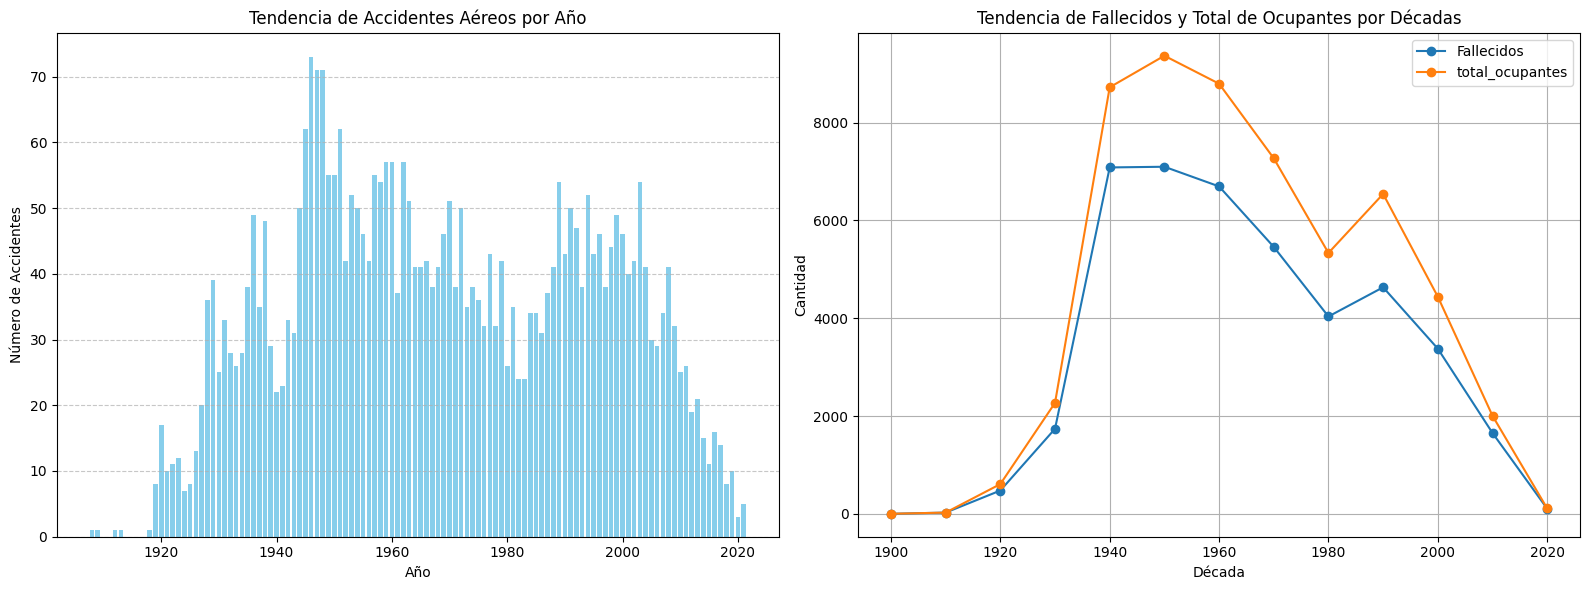

In [24]:
# Convierte la columna 'fecha' a tipo de dato datetime
accidentes['fecha'] = pd.to_datetime(accidentes['fecha'])

# Agrupa los datos por año y cuenta la cantidad de accidentes por año
accidentes_por_anio = accidentes.groupby('anio').size()

# Agrupa los datos por décadas y calcula las sumas
df_decades = accidentes.groupby(accidentes['fecha'].dt.year // 10 * 10)[['fallecidos', 'total_ocupantes']].sum()

# Configurar la figura y los subgráficos (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Gráfico de barras para mostrar la tendencia de accidentes por año
axes[0].bar(accidentes_por_anio.index, accidentes_por_anio.values, color='skyblue')
axes[0].set_title('Tendencia de Accidentes Aéreos por Año')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Número de Accidentes')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de líneas para mostrar la tendencia de fallecidos y total_ocupantes por décadas
axes[1].plot(df_decades.index, df_decades['fallecidos'], label='Fallecidos', marker='o')
axes[1].plot(df_decades.index, df_decades['total_ocupantes'], label='total_ocupantes', marker='o')
axes[1].set_title('Tendencia de Fallecidos y Total de Ocupantes por Décadas')
axes[1].set_xlabel('Década')
axes[1].set_ylabel('Cantidad')
axes[1].grid(True)
axes[1].legend()

# Mostrar los gráficos uno al lado del otro
plt.tight_layout()
plt.show()

El gráfico muestra la 'Tendencia de Accidentes Aéreos por Año'. Aquí se puede observar un patrón interesante en la frecuencia de accidentes aéreos a lo largo del tiempo. Hasta el año 1935, la cantidad de accidentes se mantuvo en niveles relativamente bajos y estables. Sin embargo, a partir de ese año, se evidencia un incremento significativo en la frecuencia de accidentes, alcanzando un pico de 75 accidentes en el año 1950.

A partir de ese punto, la cantidad de accidentes se mantuvo casi constante durante varias décadas, hasta llegar al año 2010. En ese momento, comenzó a notarse un descenso notable en la cantidad de accidentes, y esta tendencia a la baja continuó de manera marcada. En el año 2010, la cantidad de accidentes aéreos se redujo a un mínimo de 15.

Este análisis de tendencia revela una notable fluctuación en la seguridad de la aviación a lo largo de los años, con un período de aumento de accidentes seguido por una marcada mejora en la seguridad aérea a partir del año 2010."

## 2. Análisis de factores influyentes:

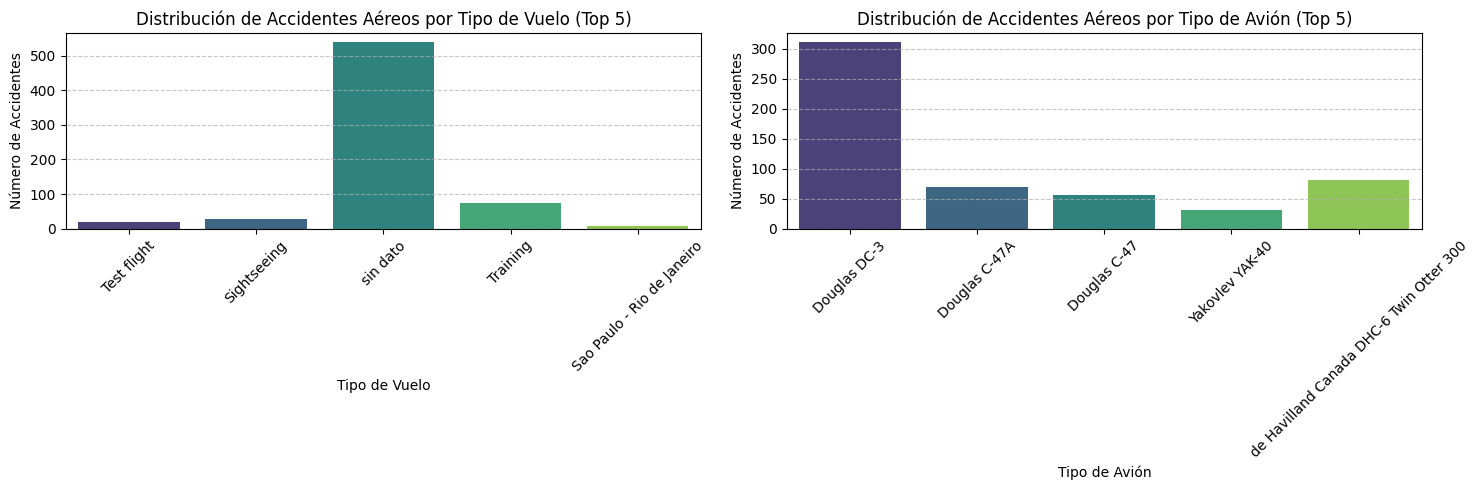

In [25]:
# Establece el número de filas y columnas para la cuadrícula de subgráficos
num_filas = 1
num_columnas = 2

# Crear una figura con subgráficos en forma de mosaico
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, 5))  # Ajusta la figura a un tamaño más estrecho

# Gráfico de barras para el tipo de vuelo (mostrar solo las 5 categorías más comunes)
n_categorias_vuelo = 5
categorias_vuelo = accidentes['tipo_vuelo'].value_counts().nlargest(n_categorias_vuelo).index
sns.countplot(data=accidentes[accidentes['tipo_vuelo'].isin(categorias_vuelo)], x='tipo_vuelo', palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Accidentes Aéreos por Tipo de Vuelo (Top 5)')
axs[0].set_xlabel('Tipo de Vuelo')
axs[0].set_ylabel('Número de Accidentes')
axs[0].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de barras para el tipo de avión (mostrar solo las 5 categorías más comunes)
n_categorias_avion = 5
categorias_avion = accidentes['tipo_avion'].value_counts().nlargest(n_categorias_avion).index
sns.countplot(data=accidentes[accidentes['tipo_avion'].isin(categorias_avion)], x='tipo_avion', palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Accidentes Aéreos por Tipo de Avión (Top 5)')
axs[1].set_xlabel('Tipo de Avión')
axs[1].set_ylabel('Número de Accidentes')
axs[1].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajusta la disposición de los subgráficos
plt.tight_layout()

# Muestra la figura
plt.show()

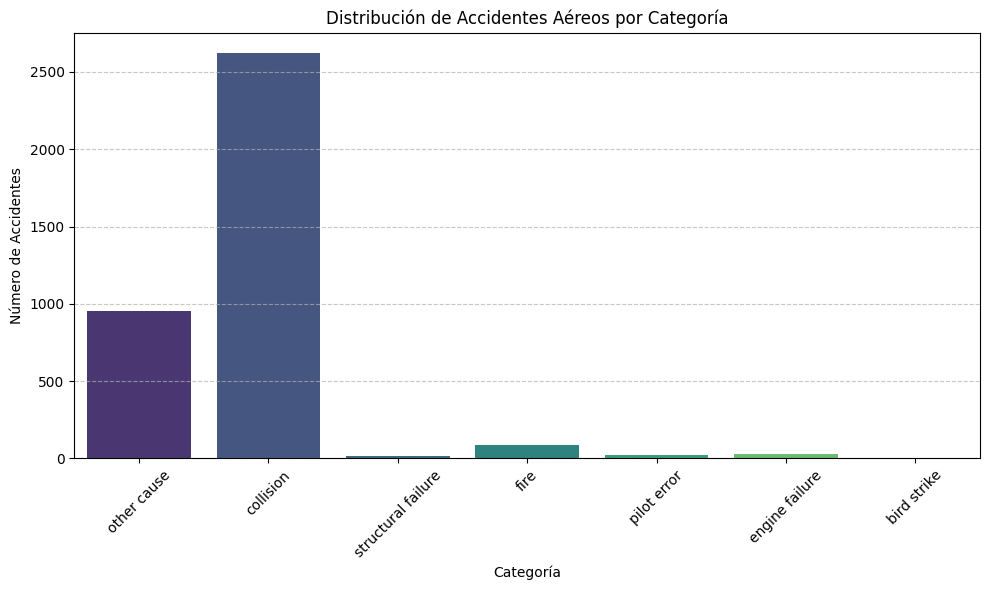

In [26]:
# Establece el número de filas y columnas para la cuadrícula de subgráficos
num_filas = 1
num_columnas = 1  # Cambia a 1 columna para un solo gráfico

# Crear una figura con un solo subgráfico
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(10, 6))

# Gráfico de barras para la categoría (mostrar todas las categorías)
sns.countplot(data=accidentes, x='categoria', palette='viridis', ax=axs)
axs.set_title('Distribución de Accidentes Aéreos por Categoría')
axs.set_xlabel('Categoría')
axs.set_ylabel('Número de Accidentes')
axs.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
axs.grid(axis='y', linestyle='--', alpha=0.7)

# Ajusta la disposición de los subgráficos
plt.tight_layout()

# Muestra la figura
plt.show()

**Tipo de vuelo**

La categoría "Sin Dato" es la más destacada en términos de accidentes aéreos, lo que sugiere que la falta de información puede ser un factor importante en los accidentes. Esto podría deberse a una variedad de factores, como la falta de informes completos de accidentes, la falta de seguimiento de los accidentes o la falta de información sobre las causas de los accidentes.

Las categorías "Training" y "Test Flight" también presentan un número significativo de accidentes, lo que sugiere que las actividades de capacitación y pruebas pueden ser propensas a accidentes. Esto podría deberse a que los pilotos y las aeronaves están bajo mayor estrés durante estas actividades, lo que aumenta el riesgo de errores.

**Tipo de avión**

El avión "Douglas DC-3" es el tipo de avión más comúnmente involucrado en accidentes aéreos, lo que podría indicar que este modelo específico puede tener desafíos de seguridad. Sin embargo, es importante tener en cuenta que el DC-3 es un avión antiguo que ha estado en servicio durante muchos años. Es posible que su mayor participación en accidentes se deba a su antigüedad y al hecho de que ha sido operado por una variedad de operadores en una variedad de condiciones.

Los aviones "De Havilland Canada DHC-6 Twin Otter 300" y "Douglas C-47A" también muestran una incidencia considerable en accidentes. Estos aviones son modelos pequeños y ligeros que pueden ser más propensos a accidentes en condiciones climáticas adversas o en entornos montañosos.

**Categoría**

La categoría "Collision" lidera en términos de accidentes, lo que sugiere que las colisiones son un factor importante en los accidentes aéreos. Esto podría deberse a una variedad de factores, como el tráfico aéreo congestionado, los errores de los pilotos y las condiciones climáticas adversas.

La categoría "Other Cause" también presenta un número significativo de accidentes, lo que indica que existen diversas causas detrás de los accidentes aéreos, distintas de las colisiones. Estas causas pueden incluir fallos mecánicos, errores humanos, condiciones climáticas adversas y actos de interferencia ilícita.

**Conclusiones**

**En general, los datos sugieren que la falta de información, las actividades de capacitación y pruebas, así como las colisiones, son factores influyentes clave en los accidentes aéreos. Estos hallazgos podrían ser útiles para enfocar futuros esfuerzos de seguridad y prevención de accidentes en la industria de la aviación.**

## 3. Análisis de víctimas y sobrevivientes:

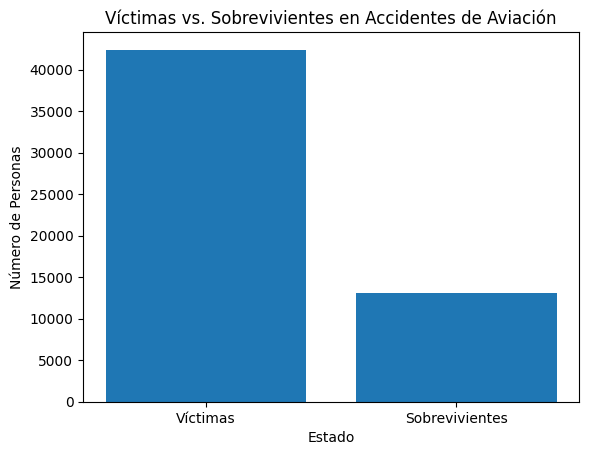

In [27]:
# Crear una nueva columna para calcular el número de sobrevivientes
accidentes['sobrevivientes'] = accidentes['total_ocupantes'] - accidentes['fallecidos']

# Suma el número de víctimas y sobrevivientes
total_victimas = accidentes['fallecidos'].sum()
total_sobrevivientes = accidentes['sobrevivientes'].sum()

# Crear un gráfico de barras para visualizar víctimas vs. sobrevivientes
plt.bar(['Víctimas', 'Sobrevivientes'], [total_victimas, total_sobrevivientes])
plt.xlabel('Estado')
plt.ylabel('Número de Personas')
plt.title('Víctimas vs. Sobrevivientes en Accidentes de Aviación')
plt.show()

El gráfico muestra claramente una diferencia significativa entre el número de personas fallecidas y el número de personas sobrevivientes en accidentes de aviación. La discrepancia entre el número de fallecidos y sobrevivientes sugiere que la seguridad en la aviación es un aspecto crítico que necesita atención y mejora continua. Los accidentes de aviación pueden tener un alto costo en términos de vidas humanas, y es importante que la industria continúe trabajando en la mejora de las medidas de seguridad para reducir las pérdidas de vidas en futuros incidentes.

**Este análisis resalta la importancia de seguir mejorando la seguridad y las prácticas en la industria de la aviación para reducir la cantidad de víctimas en caso de accidentes.**

## 4. Análisis de destinos y compañías:

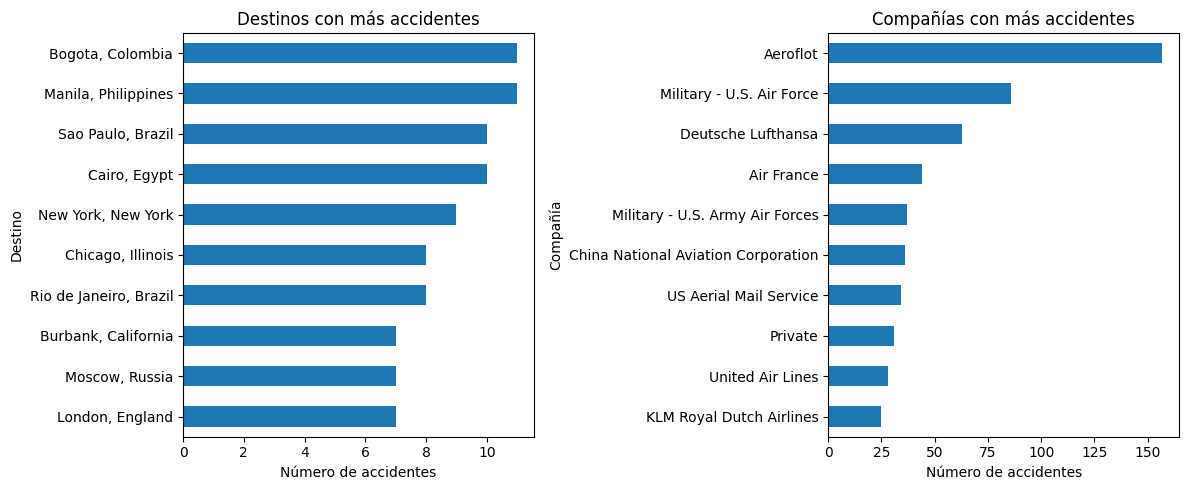

In [28]:

# Contar accidentes por destino
accidentes_por_destino = accidentes['destino'].value_counts()

# Contar accidentes por compañía
accidentes_por_compania = accidentes['compañia'].value_counts()

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila y 2 columnas de subplots

# Visualizar los destinos con más accidentes en el primer subplot (gráfico de barras horizontal)
accidentes_por_destino.head(10).sort_values(ascending=True).plot(kind='barh', title='Destinos con más accidentes', ax=ax1)
ax1.set_xlabel('Número de accidentes')
ax1.set_ylabel('Destino')

# Visualizar las compañías con más accidentes en el segundo subplot (gráfico de barras horizontal)
accidentes_por_compania.head(10).sort_values(ascending=True).plot(kind='barh', title='Compañías con más accidentes', ax=ax2)
ax2.set_xlabel('Número de accidentes')
ax2.set_ylabel('Compañía')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

**El destino con más accidentes es Filipinas, con un número de accidentes de 14:** Esto se debe a una serie de factores, como las condiciones climáticas adversas, la topografía accidentada y la falta de infraestructura aeroportuaria. La topografía accidentada de Filipinas también puede contribuir al riesgo de accidentes. El país tiene muchas montañas, valles y ríos, lo que puede hacer que sea difícil aterrizar o despegar de manera segura.

La falta de infraestructura aeroportuaria en Filipinas también puede contribuir al riesgo de accidentes. Muchos aeropuertos del país son pequeños y carecen de las últimas tecnologías de seguridad.

**La compañía con más accidentes es Aeroflot, con 160 accidentes:** Esto se debe a una serie de factores, como la antigüedad de la flota, la falta de inversión en seguridad y la corrupción. La flota de Aeroflot es una de las más antiguas del mundo. Muchos de los aviones de la compañía tienen más de 20 años. Los aviones más antiguos son más propensos a sufrir fallas mecánicas, lo que puede aumentar el riesgo de accidentes.

Aeroflot ha sido criticada por su falta de inversión en seguridad. La compañía ha sido acusada de ahorrar dinero en mantenimiento y capacitación de pilotos. Estas medidas de ahorro pueden aumentar el riesgo de accidentes. La corrupción también ha sido un problema para Aeroflot. La compañía ha sido acusada de pagar sobornos para evitar inspecciones de seguridad. Esto puede permitir que aviones con fallas mecánicas operen, lo que aumenta el riesgo de accidentes.

## Hallazgos Claves del Análisis de Accidentes Aéreos:

- La seguridad de la aviación ha mejorado significativamente en las últimas décadas. El número de accidentes aéreos ha disminuido considerablemente desde 1950.
- La falta de información, las actividades de capacitación y pruebas, así como las colisiones, son factores influyentes clave en los accidentes aéreos.
- Los accidentes aéreos pueden tener un alto costo en términos de vidas humanas. Es importante que la industria continúe trabajando en la mejora de las medidas de seguridad para reducir las pérdidas de vidas en futuros incidentes.
- Filipinas y Aeroflot son los destinos y las compañías con más accidentes, respectivamente. Esto se debe a una serie de factores, como las condiciones climáticas adversas, la antigüedad de la flota, la falta de inversión en seguridad y la corrupción.

## Recomendaciones:

1. Mejorar la recopilación y el análisis de datos sobre accidentes aéreos. Esto permitiría identificar las causas específicas de los accidentes y desarrollar medidas de prevención más efectivas.
2. Desarrollar programas de capacitación y pruebas más seguros. Esto ayudaría a reducir los errores humanos, que son una causa importante de accidentes aéreos.
3. Tomar medidas para reducir las colisiones aéreas. Esto podría incluir la mejora de la gestión del tráfico aéreo y la implementación de nuevas tecnologías de seguridad.
4. Mejorar la seguridad en los destinos y las compañías con más accidentes. Esto podría incluir la inversión en infraestructura aeroportuaria, la actualización de las flotas aéreas y la mejora de los estándares de seguridad.
5. El KPI de tasa anual de mortalidad, que se mide en una base de datos de accidentes aéreos, oscila entre el 50% y el 100% para la mayoría de los años. Esto significa que, en promedio, por cada 100 personas que mueren en un accidente aéreo, entre 50 y 100 son los sobrevivientes. Esta tasa es alta y preocupante, ya que indica que hay un problema de seguridad aérea. Es importante que esta tasa esté por debajo del target de tasa conforme al KPI indicado.
6. La tasa anual de supervivencia en accidentes aéreos es un indicador importante de la seguridad aérea. Esta tasa oscila entre el 0% y el 50% para la mayoría de los años, lo que significa que, en promedio, por cada 100 personas que mueren en un accidente aéreo, entre 0 y 50 son los sobrevivientes. Esta tasa es baja y preocupante, ya que indica que hay un problema de seguridad aérea. Es importante que esta tasa esté por encima del 50% para que los pasajeros y la tripulación tengan una mayor probabilidad de sobrevivir en caso de accidente.

Estos hallazgos y recomendaciones son importantes para la industria de la aviación. Al abordar los factores que contribuyen a los accidentes aéreos, se puede ayudar a crear una industria más segura para todos.

In [29]:
accidentes.columns

Index(['fecha', 'hora', 'destino', 'compañia', 'tipo_vuelo', 'tipo_avion',
       'registro', 'id_aeronave', 'total_ocupantes', 'pasajeros_a_bordo',
       'tripulacion_a_bordo', 'fallecidos', 'pasajeros_fallecidos',
       'tripulacion_fallecida', 'fallecidos_en_tierra', 'resumen', 'pais',
       'anio', 'mes', 'categoria', 'sobrevivientes'],
      dtype='object')

In [31]:
# Guardado de dataframe en formato csv para uso posterior
nombre_archivo = 'accidentes.csv'
accidentes.to_csv(nombre_archivo, index=False)

print(f"DataFrame convertido y guardado en {nombre_archivo}")

DataFrame convertido y guardado en accidentes.csv
